# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

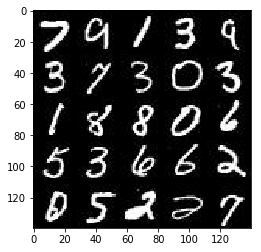

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

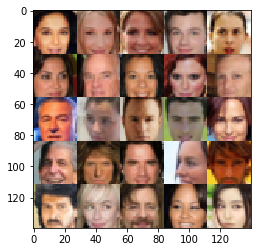

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, (), name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Conv 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # Conv 2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Conv 3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Conv 4
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        relu1 = tf.maximum(alpha * x1, x1)
        
        # Start convolutional transpose stack
        x2 = tf.layers.conv2d_transpose(relu1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * x4, x4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 3, strides=2, padding='same')
        
        # Output
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2540... Generator Loss: 0.4325


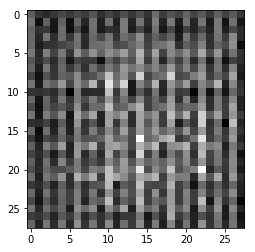

Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 5.5427


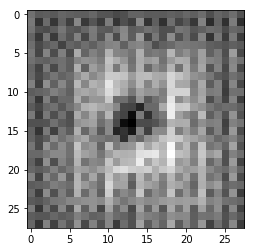

Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.3878


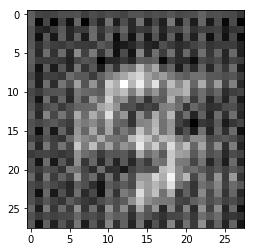

Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 2.0177


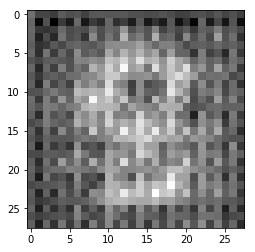

Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 2.2486


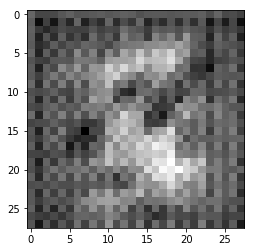

Epoch 1/2... Discriminator Loss: 2.4298... Generator Loss: 8.4564


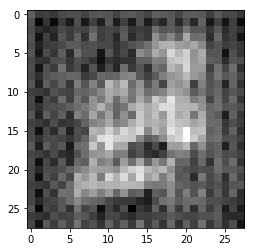

Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 2.3696


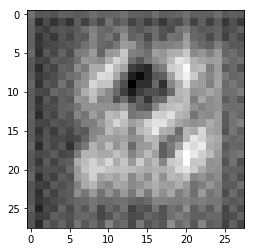

Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.5433


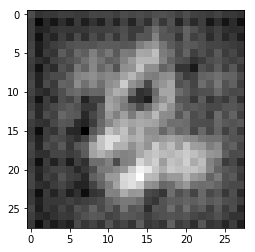

Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 1.7204


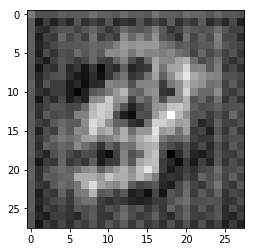

Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.2685


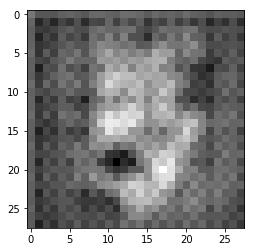

Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 1.9246


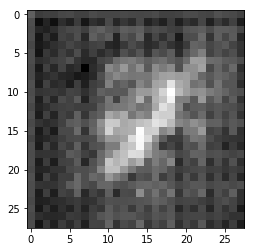

Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 2.2844


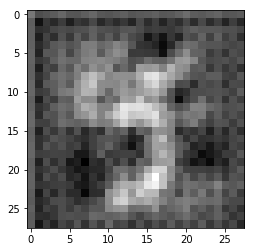

Epoch 1/2... Discriminator Loss: 0.5779... Generator Loss: 1.8448


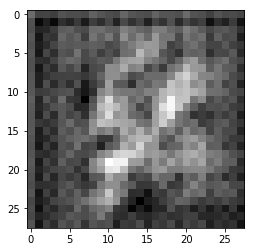

Epoch 1/2... Discriminator Loss: 1.6739... Generator Loss: 0.4529


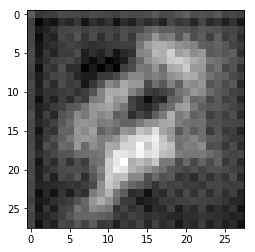

Epoch 1/2... Discriminator Loss: 0.6646... Generator Loss: 1.7445


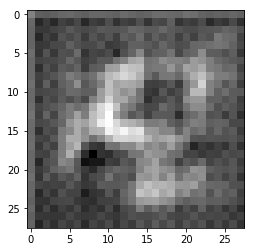

Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.9440


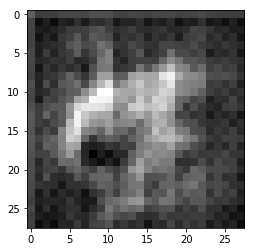

Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 1.7332


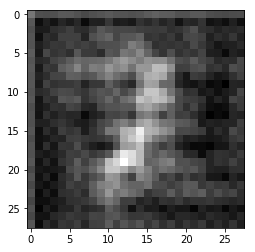

Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.0814


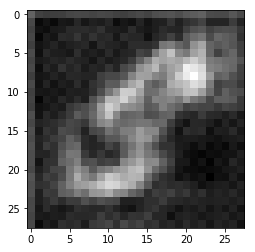

Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.0300


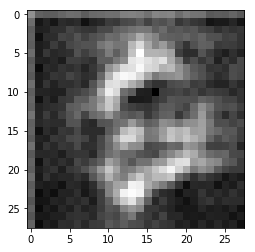

Epoch 1/2... Discriminator Loss: 2.7006... Generator Loss: 0.1498


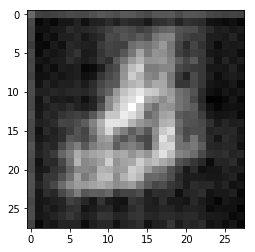

Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 1.5581


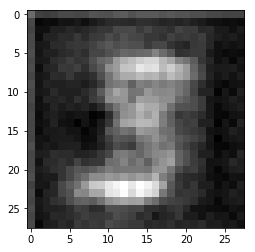

Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.3244


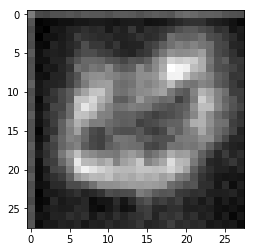

Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.4232


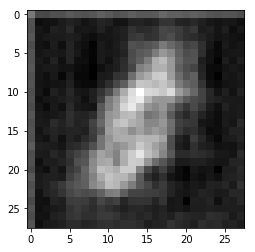

Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 1.0402


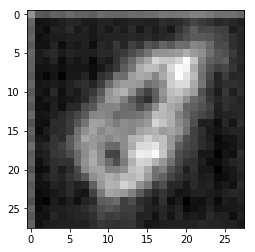

Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 0.9968


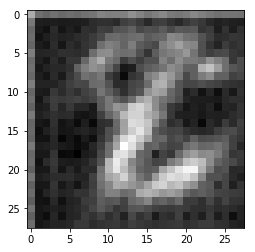

Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.2894


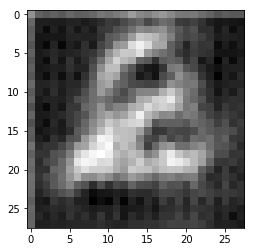

Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.0431


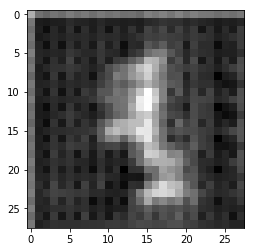

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.2502


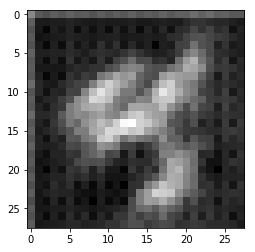

Epoch 1/2... Discriminator Loss: 1.8013... Generator Loss: 0.4051


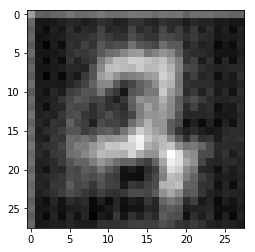

Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.6514


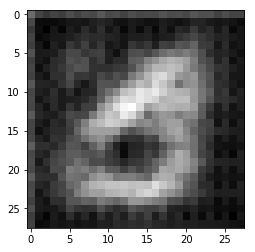

Epoch 1/2... Discriminator Loss: 1.8515... Generator Loss: 0.4300


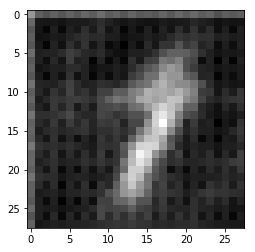

Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 1.1292


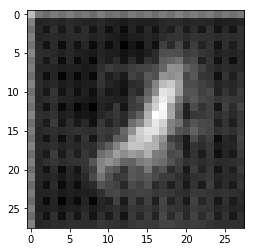

Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.3435


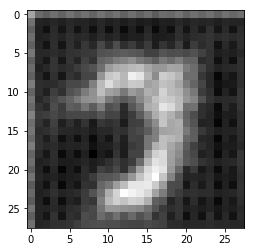

Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 2.6627


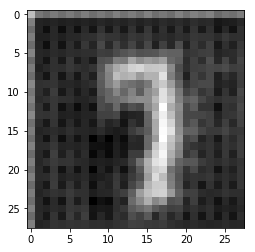

Epoch 1/2... Discriminator Loss: 0.6182... Generator Loss: 1.5262


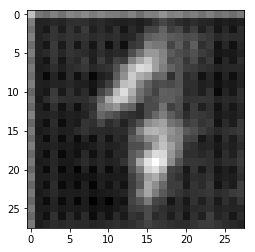

Epoch 1/2... Discriminator Loss: 1.0849... Generator Loss: 0.9449


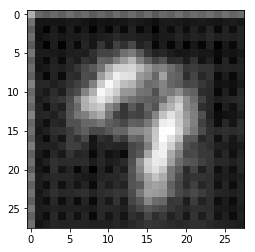

Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.0239


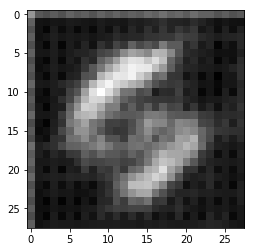

Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 1.3595


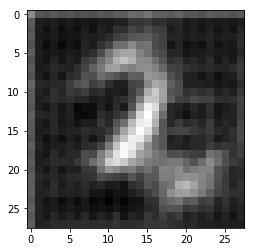

Epoch 1/2... Discriminator Loss: 0.4293... Generator Loss: 2.6778


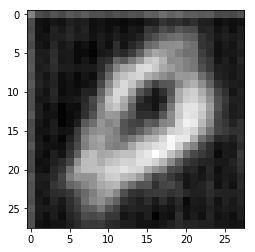

Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 0.5284


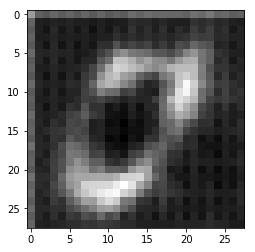

Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.3175


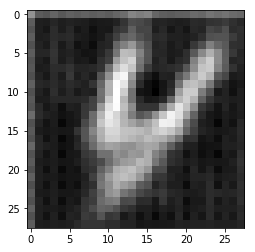

Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.7659


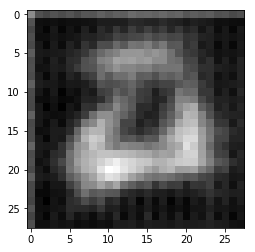

Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.9864


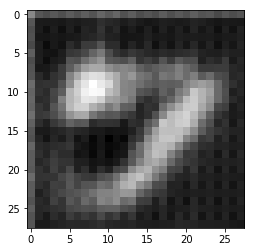

Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.0268


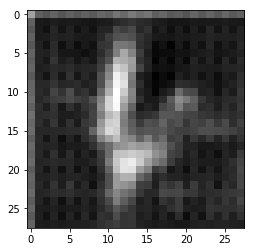

Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 1.6798


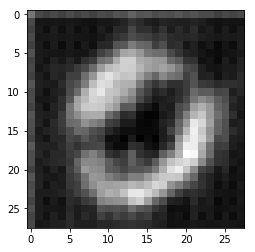

Epoch 1/2... Discriminator Loss: 1.9494... Generator Loss: 0.3684


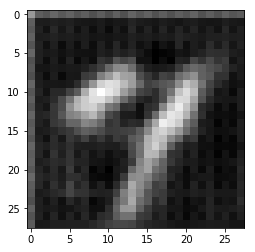

Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.0573


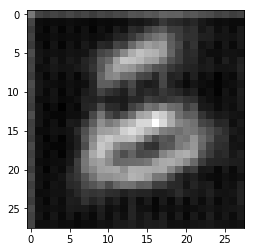

Epoch 1/2... Discriminator Loss: 1.2024... Generator Loss: 0.7094


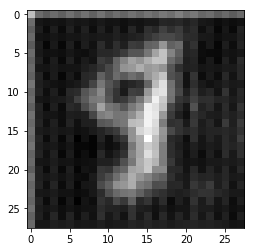

Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.5990


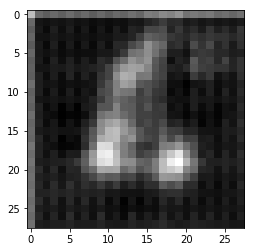

Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.8703


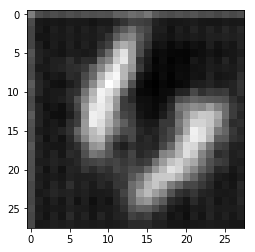

Epoch 1/2... Discriminator Loss: 0.6549... Generator Loss: 1.5368


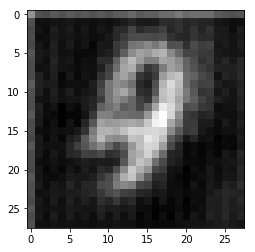

Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 0.4238


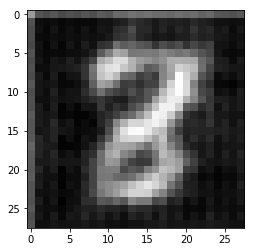

Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 2.6353


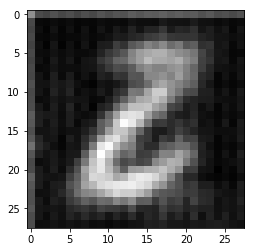

Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.7290


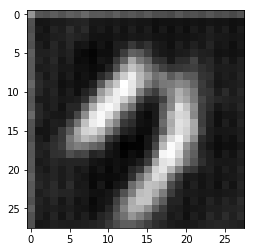

Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.7667


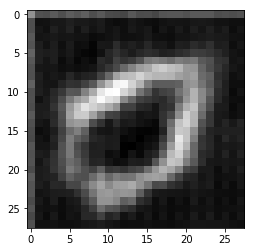

Epoch 1/2... Discriminator Loss: 1.5614... Generator Loss: 0.5100


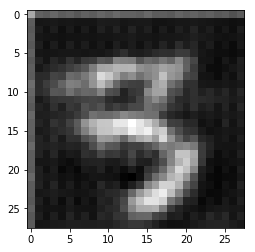

Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 2.4345


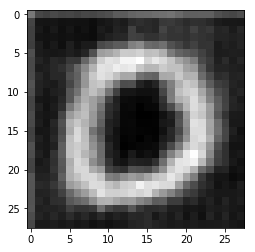

Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.1863


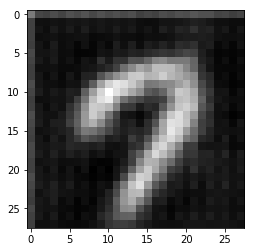

Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.8270


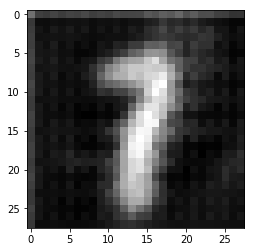

Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 0.9410


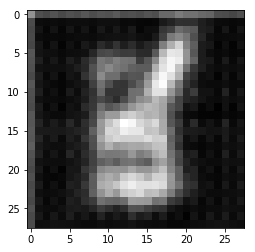

Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 2.2838


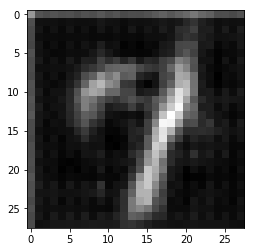

Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.4944


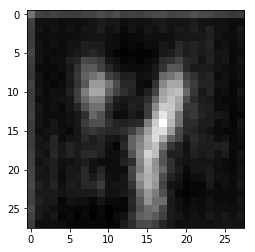

Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.1970


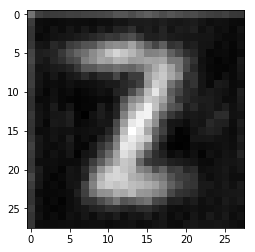

Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.3341


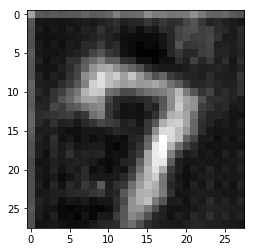

Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.3137


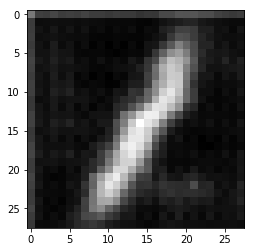

Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.7618


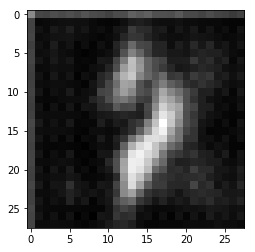

Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.0617


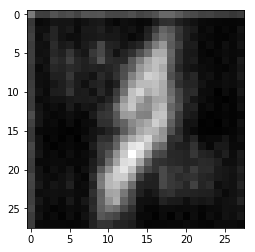

Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.6284


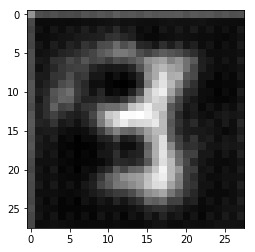

Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 1.0107


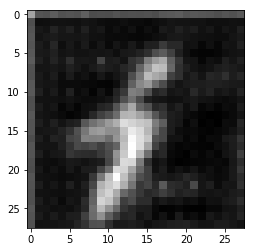

Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.0776


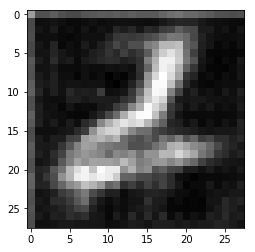

Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.5521


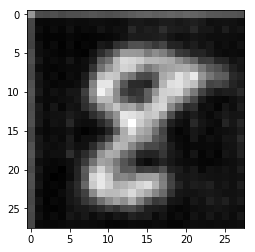

Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.6704


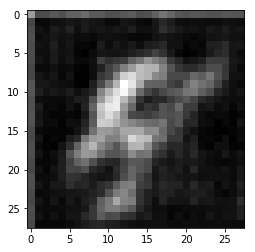

Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 0.8139


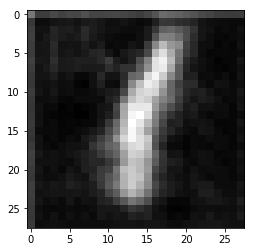

Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.7546


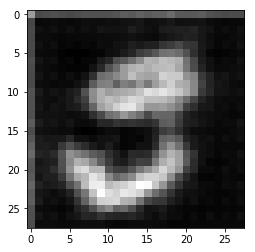

Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.5011


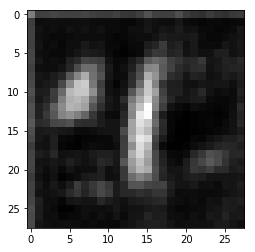

Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 1.0919


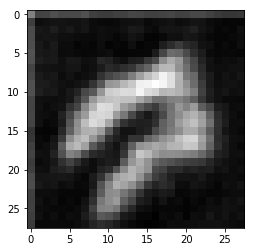

Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 1.3748


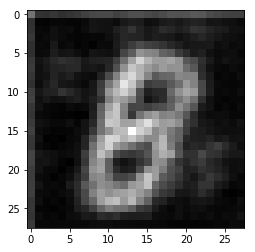

Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.6650


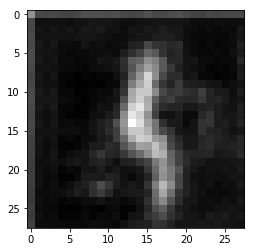

Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.6189


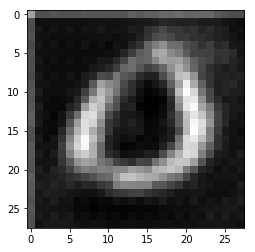

Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.3049


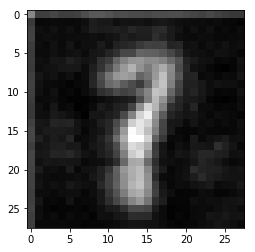

Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 2.4681


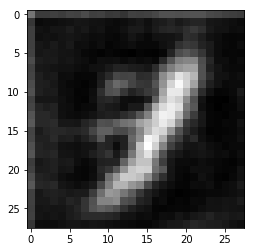

Epoch 2/2... Discriminator Loss: 0.4657... Generator Loss: 2.6922


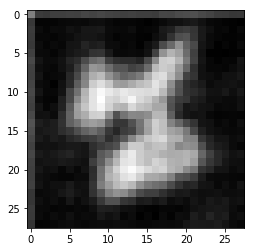

Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 2.5259


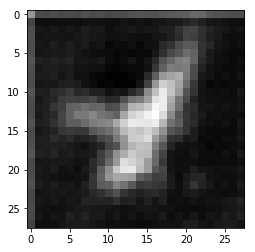

Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.5445


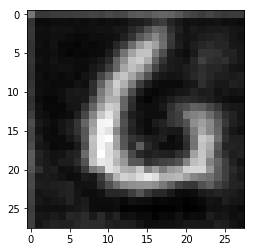

Epoch 2/2... Discriminator Loss: 2.0761... Generator Loss: 0.2692


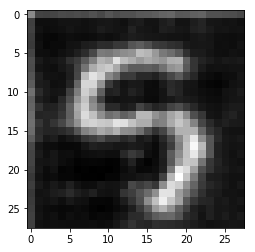

Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 1.4264


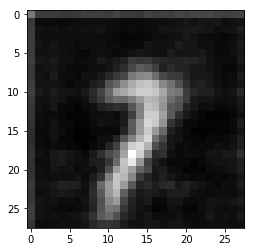

Epoch 2/2... Discriminator Loss: 0.4602... Generator Loss: 2.5596


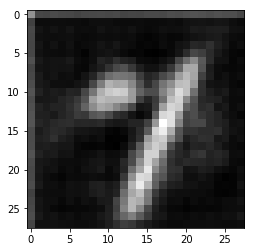

Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.9405


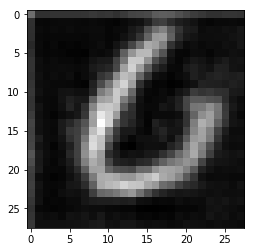

Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.9155


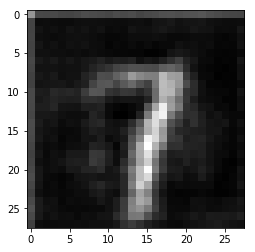

Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 1.0822


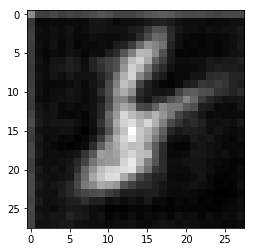

Epoch 2/2... Discriminator Loss: 0.5863... Generator Loss: 1.5853


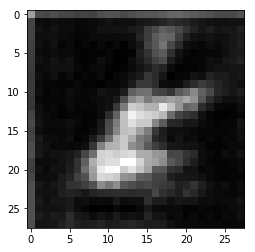

Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 1.1296


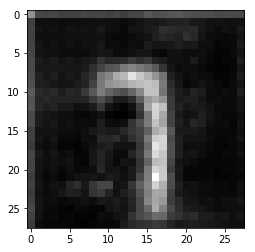

Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 1.0814


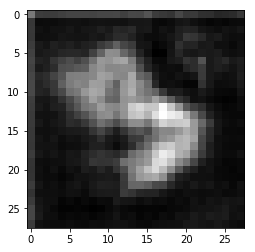

Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 2.5521


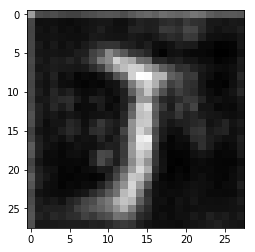

Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.3676


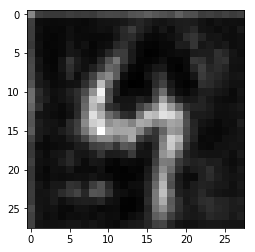

Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 2.4925


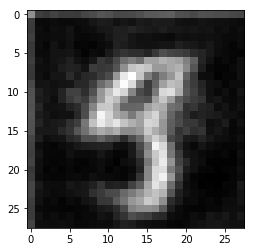

Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 0.7163


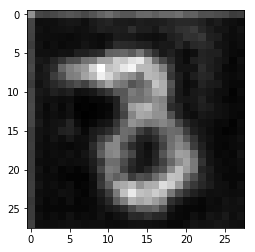

Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.5218


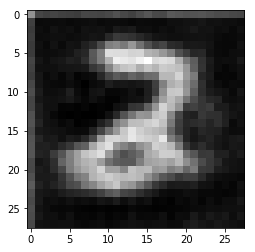

Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.5992


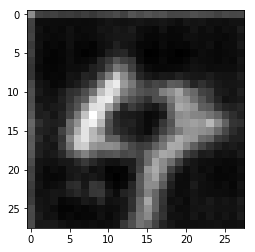

Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 1.4391


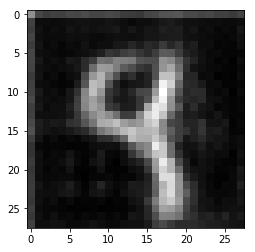

Epoch 2/2... Discriminator Loss: 0.4264... Generator Loss: 2.6898


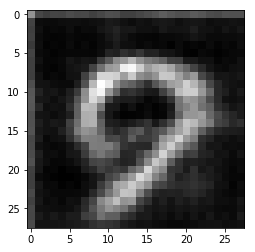

Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6301


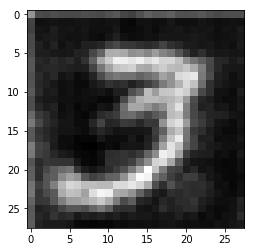

Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.4214


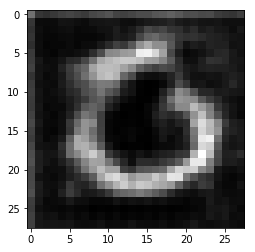

Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.2593


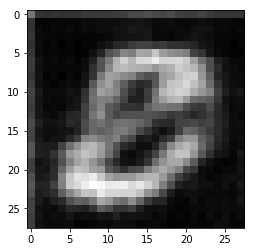

Epoch 2/2... Discriminator Loss: 0.7974... Generator Loss: 1.3031


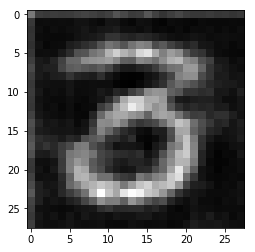

Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 0.7790


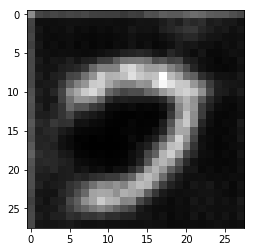

Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.4184


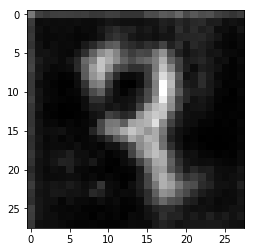

Epoch 2/2... Discriminator Loss: 0.5431... Generator Loss: 2.0384


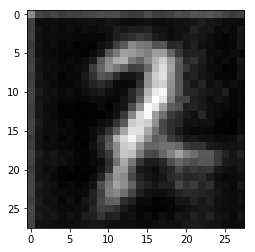

Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 3.1704


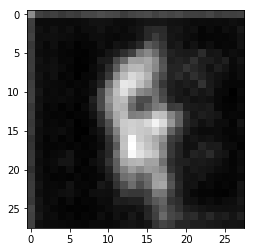

Epoch 2/2... Discriminator Loss: 0.5591... Generator Loss: 1.9363


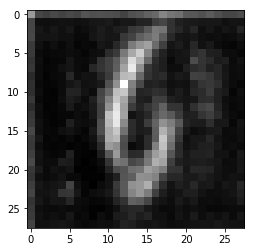

Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.3750


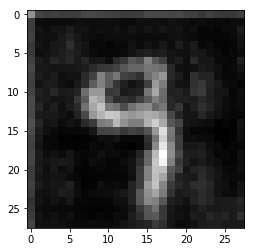

Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.6425


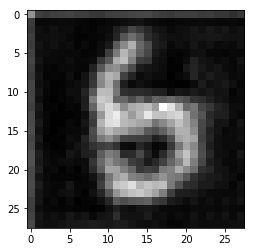

Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 2.1711


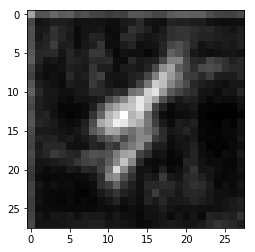

Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.9684


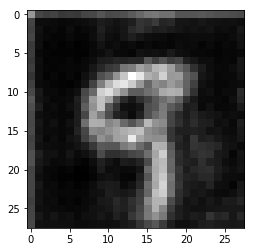

Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.0485


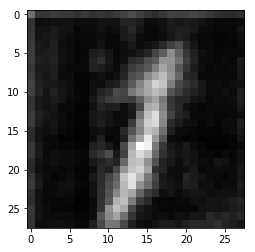

Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.7851


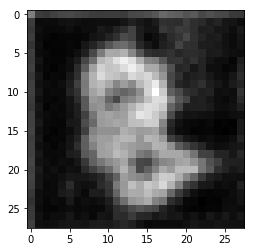

Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.6066


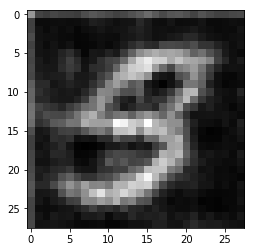

Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8572


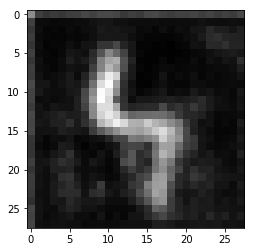

Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.2335


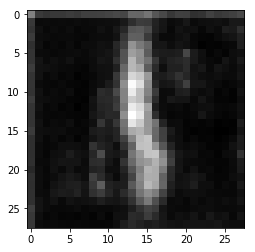

Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 4.7059


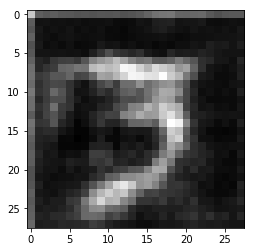

IndexError: list index out of range

In [12]:
batch_size = 10
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 8.9526


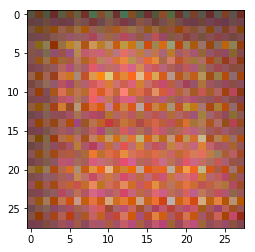

Epoch 1/1... Discriminator Loss: 2.2490... Generator Loss: 0.2716


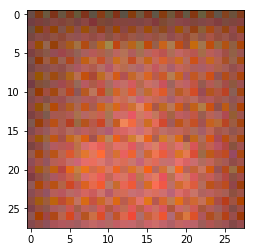

Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 2.5977


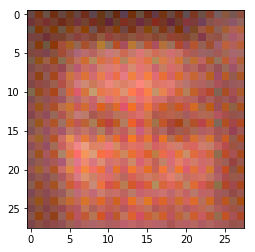

Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2849


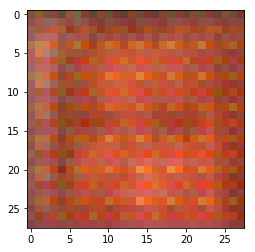

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.6897


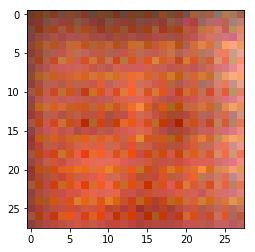

Epoch 1/1... Discriminator Loss: 1.8091... Generator Loss: 4.5440


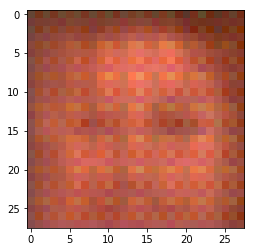

Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9480


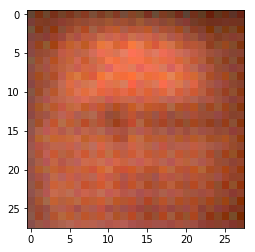

Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.5089


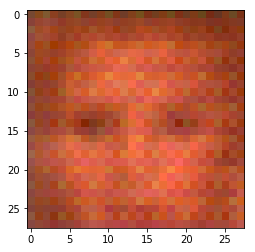

Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 2.0336


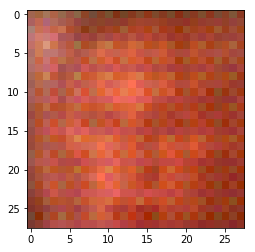

Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.4122


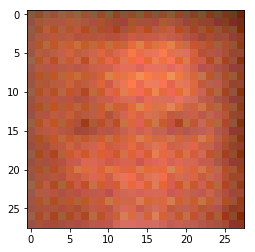

Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6968


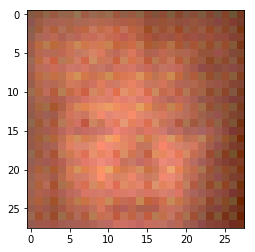

Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 3.0892


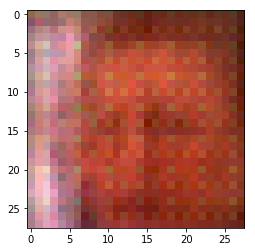

Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.6204


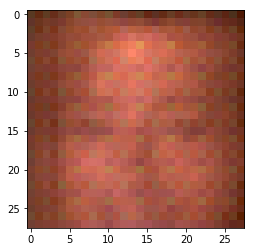

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5386


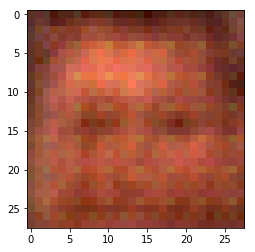

Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.3499


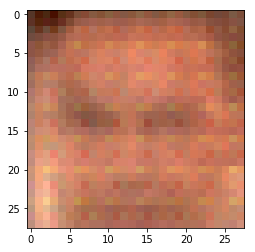

Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 0.3525


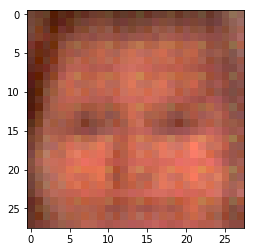

Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.6113


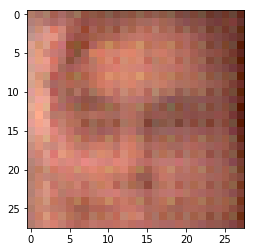

Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 2.0662


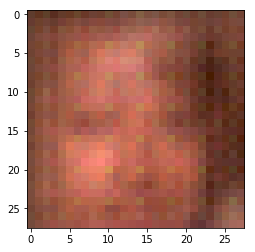

Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 2.4614


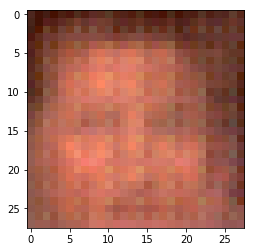

Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.7954


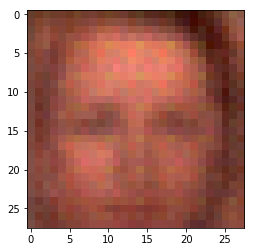

Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.3959


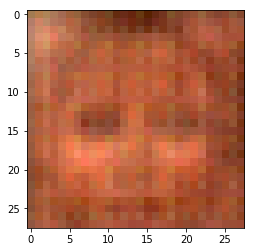

Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 2.1396


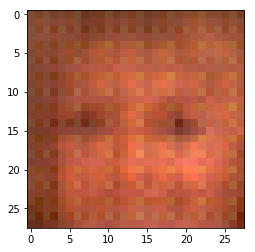

Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6269


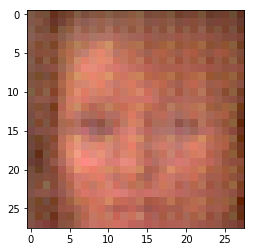

Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 2.2219


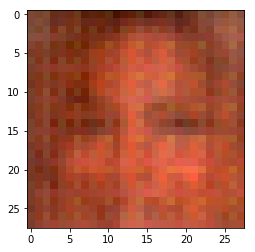

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0480


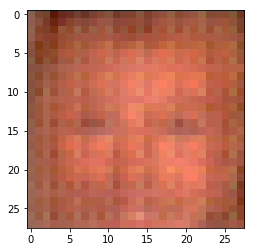

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.9786


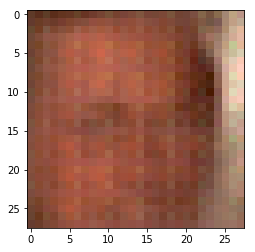

Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.3845


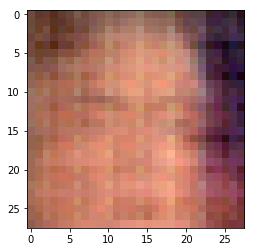

Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.8418


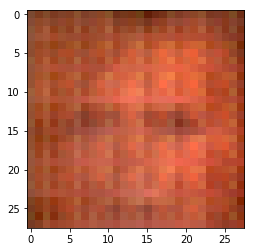

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7675


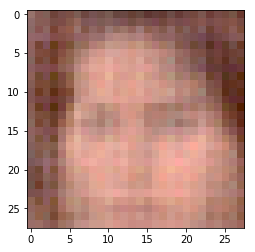

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.2473


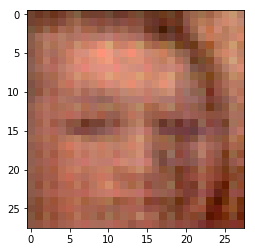

Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.6285


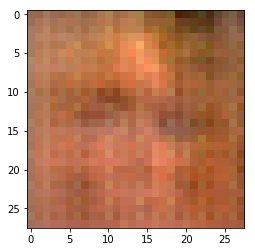

IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.